# Estimation of Obesity Levels Based On Eating Habits and Physical Condition

- **Authors:**

    - Bitewulign Kassa Mekonnen
    - Yalda Rahmati
    - Richard (Rick) Harkness
    - Gulrukh Aqeel
    - Kate Antonova

- **Technical Facilitator:**

    - Phil Van-Lane(he/him) phil.vanlane@mail.utoronto.ca
- **Learning Support Staff:**

    - Aditya Kulkarni (he/him) aditya.kulkarni@mail.utoronto.ca
    - Farzaneh Hashemi (she/her) fhashemi.ma@gmail.com
    - Sergii Khomych (he/him) svkhomich1@gmail.com

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import (RandomForestClassifier as RFC, 
                              GradientBoostingClassifier as GBC)
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import (classification_report,
                             precision_score,
                            recall_score, 
                            f1_score,
                            confusion_matrix, 
                            accuracy_score,
                            precision_recall_curve,
                            roc_auc_score,
                            roc_curve,
                            auc,
                            ConfusionMatrixDisplay,
                            precision_recall_curve, 
                             average_precision_score)
#from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import joblib
from sklearn.preprocessing import label_binarize
%matplotlib inline
import time

In [3]:
data = pd.read_csv('data/ObesityDataSet_raw_and_data_sinthetic.csv')
# Create a copy
df = data.copy()
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df.shape

(2111, 17)

In [5]:
set(df['NObeyesdad'])

{'Insufficient_Weight',
 'Normal_Weight',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III',
 'Overweight_Level_I',
 'Overweight_Level_II'}

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2111.0,24.312600,6.345968,14.00,19.947192,22.777890,26.000000,61.00
Height,2111.0,1.701677,0.093305,1.45,1.630000,1.700499,1.768464,1.98
Weight,2111.0,86.586058,26.191172,39.00,65.473343,83.000000,107.430682,173.00
FCVC,2111.0,2.419043,0.533927,1.00,2.000000,2.385502,3.000000,3.00
NCP,2111.0,2.685628,0.778039,1.00,2.658738,3.000000,3.000000,4.00
CH2O,2111.0,2.008011,0.612953,1.00,1.584812,2.000000,2.477420,3.00
FAF,2111.0,1.010298,0.850592,0.00,0.124505,1.000000,1.666678,3.00
TUE,2111.0,0.657866,0.608927,0.00,0.000000,0.625350,1.000000,2.00


In [4]:
# Check for missing values
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [6]:
# dropping dublicate rows
df.drop_duplicates(inplace=True)

In [7]:
# numerical and categorical columns

numerical_columns = [col for col in df.columns if df[col].dtype != 'O']
categorical_columns = [col for col in df.columns if df[col].dtype == 'O']

In [8]:
numerical_columns

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [9]:
categorical_columns

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'NObeyesdad']

In [10]:
discrete_columns = [col for col in df.columns if df[col].nunique() < 7]
continuous_columns = [col for col in df.columns if col not in discrete_columns]

In [12]:
continuous_columns

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'NObeyesdad']

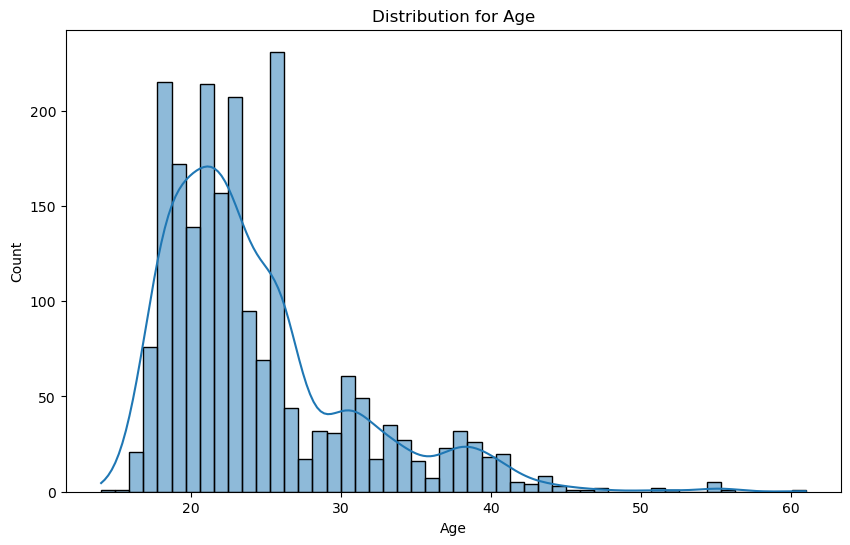

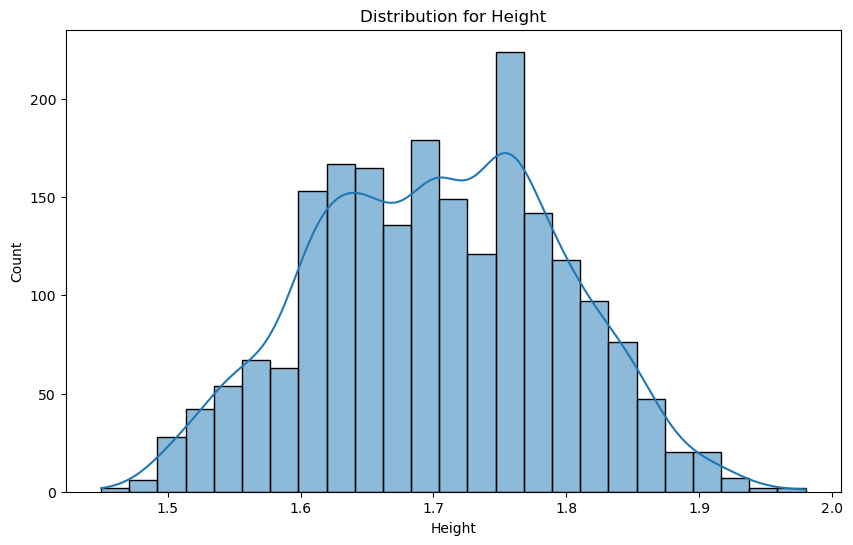

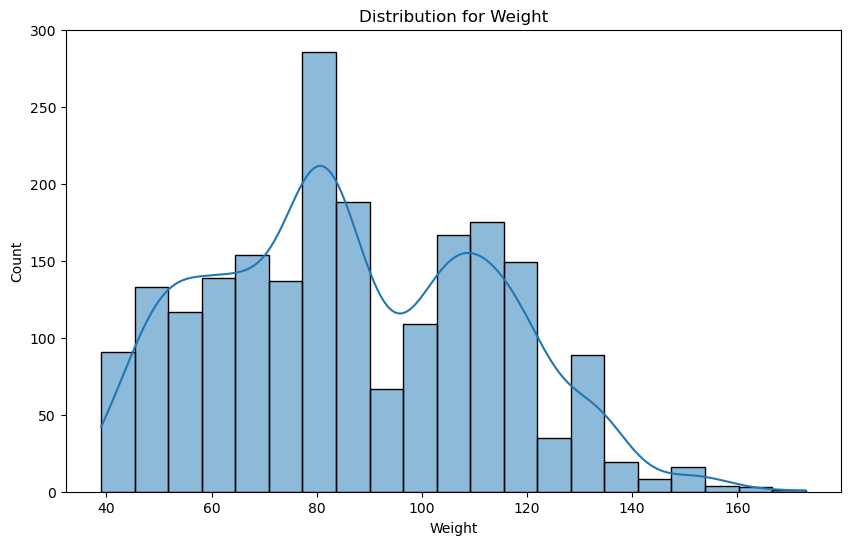

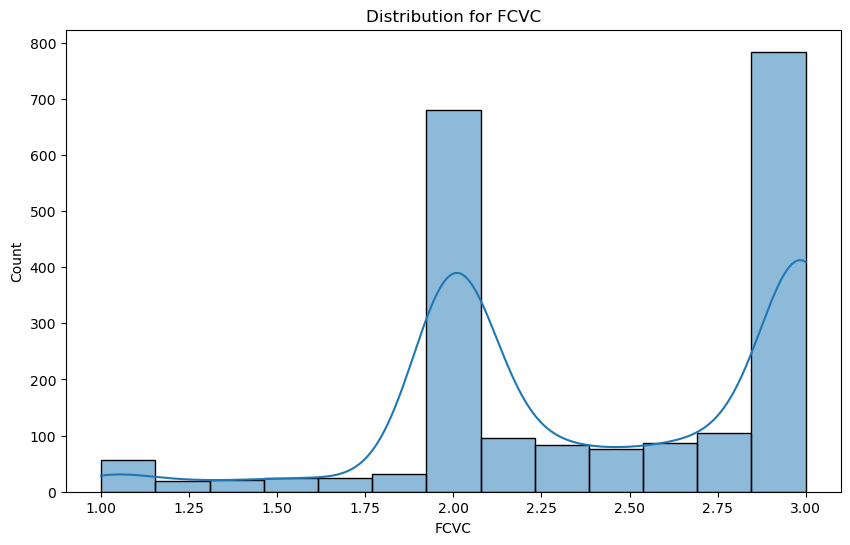

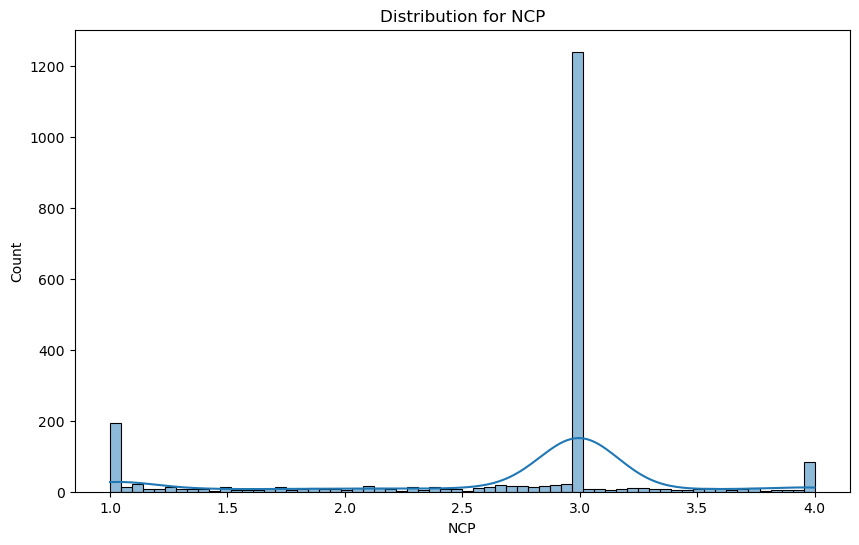

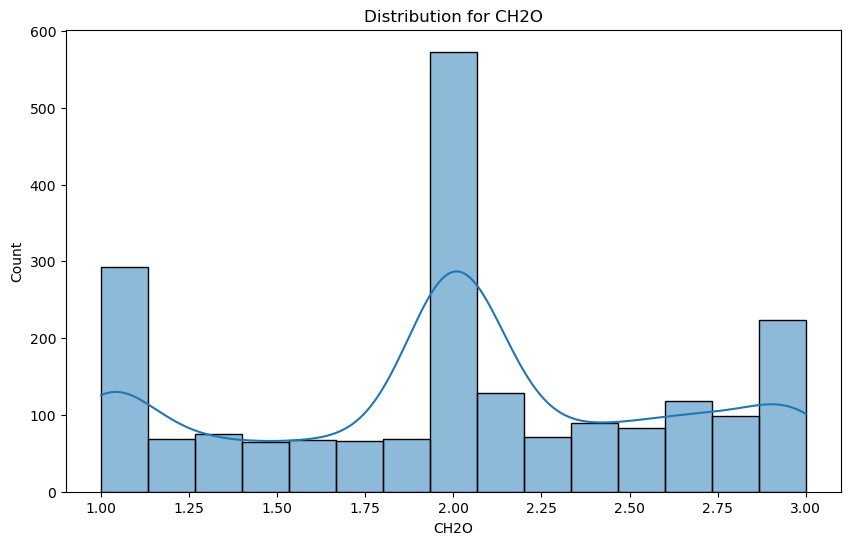

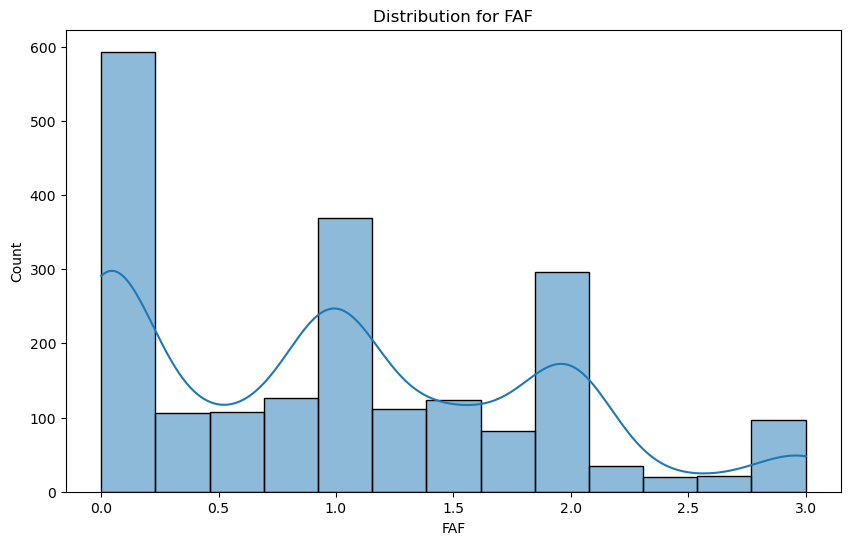

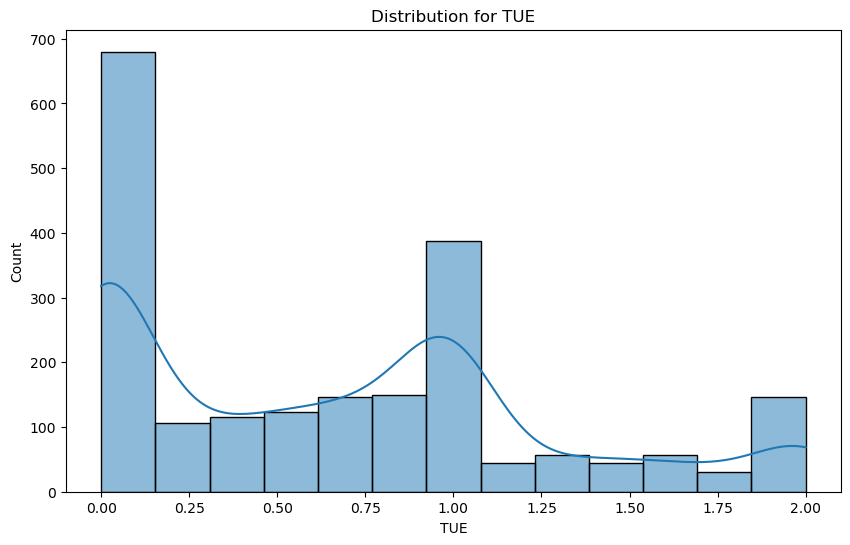

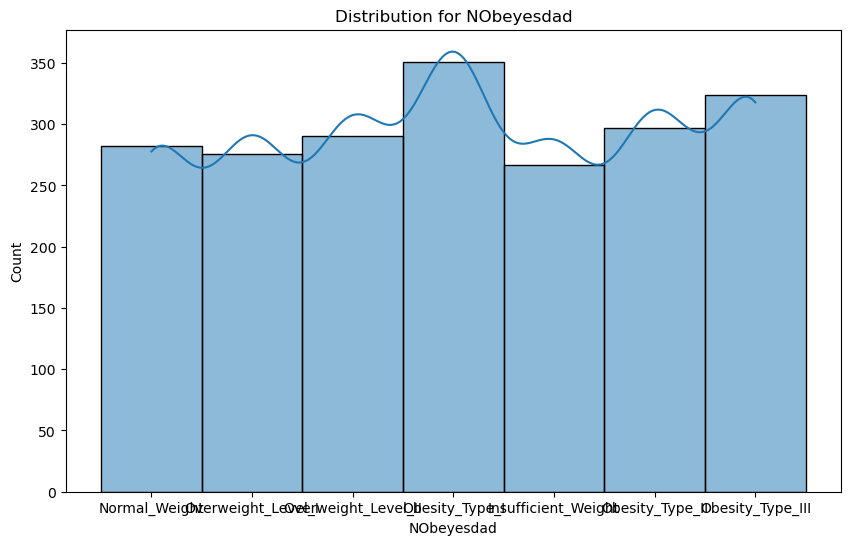

In [13]:
# Check the disstribution of data
for col in continuous_columns:
    plt.figure(figsize=(10,6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution for {col}')
    plt.show()

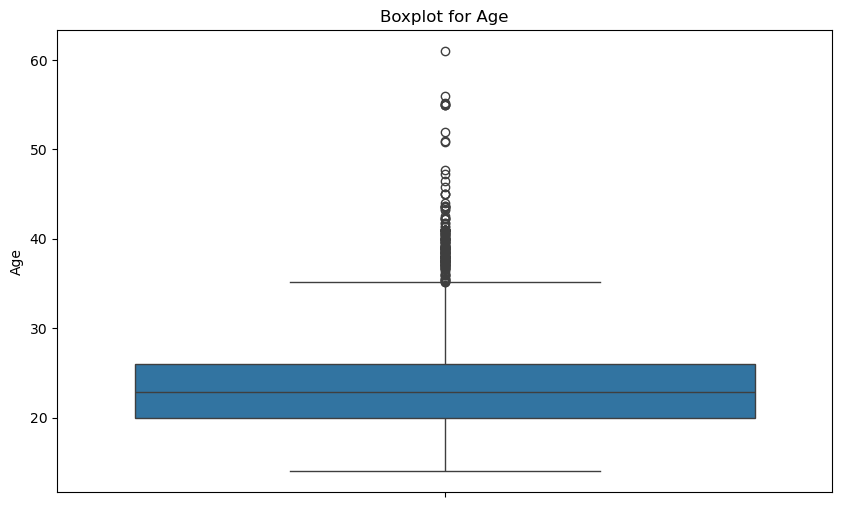

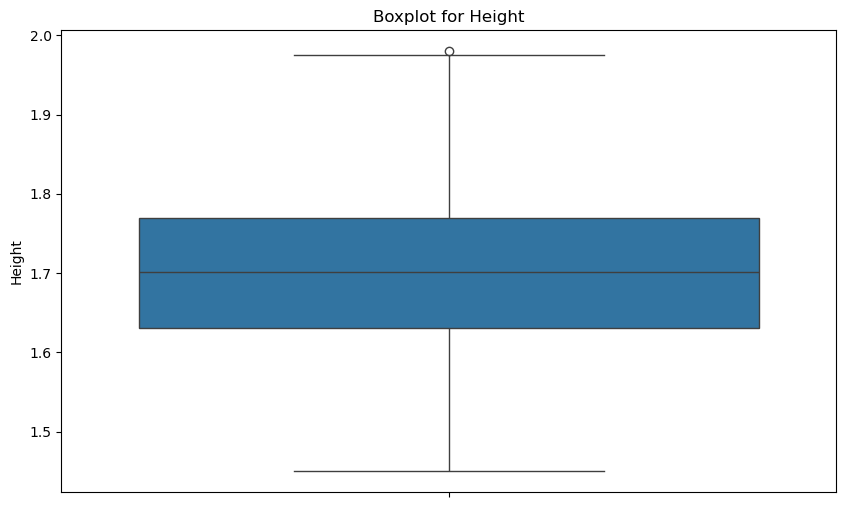

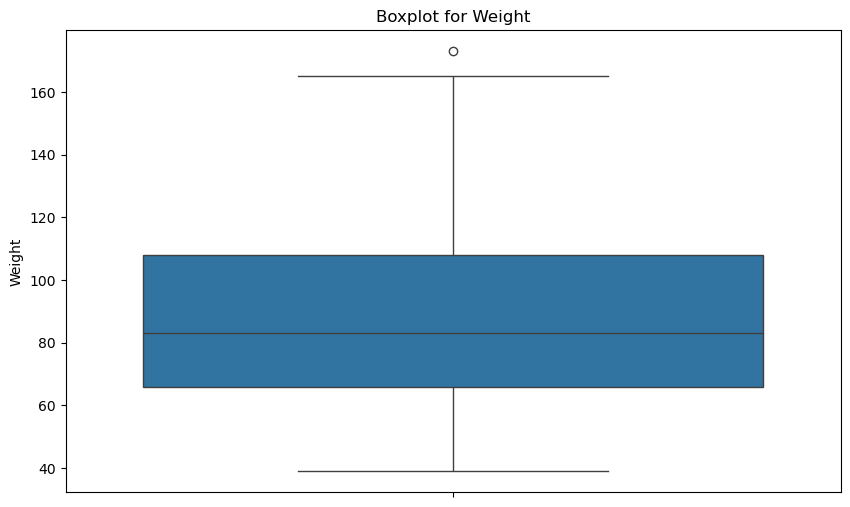

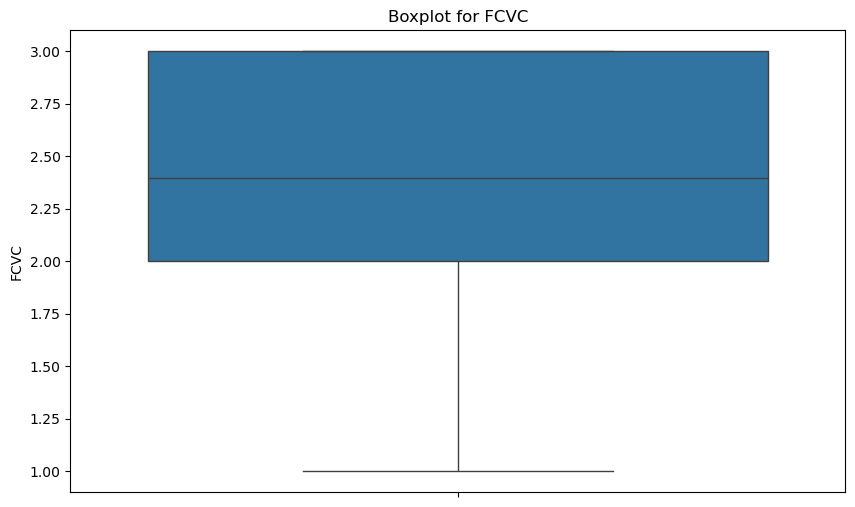

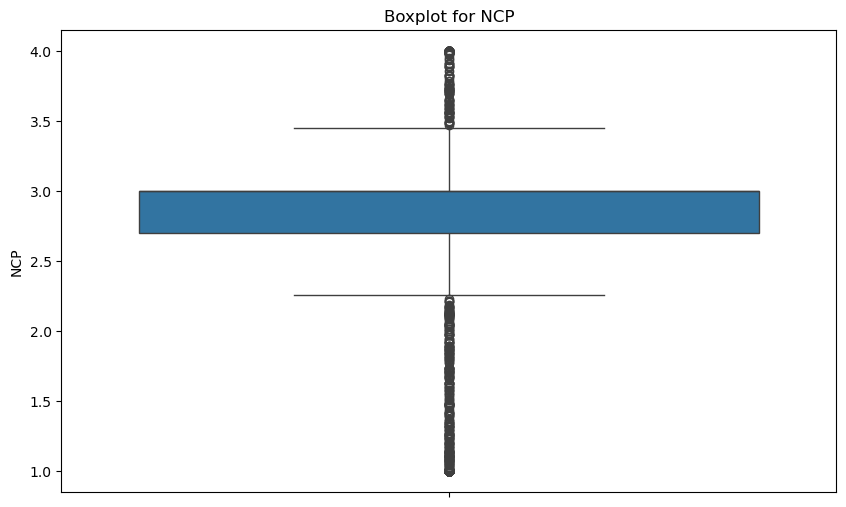

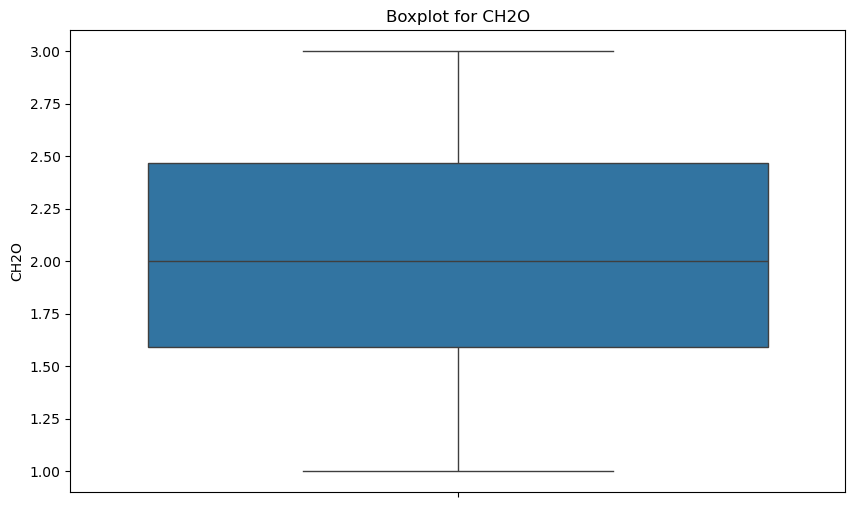

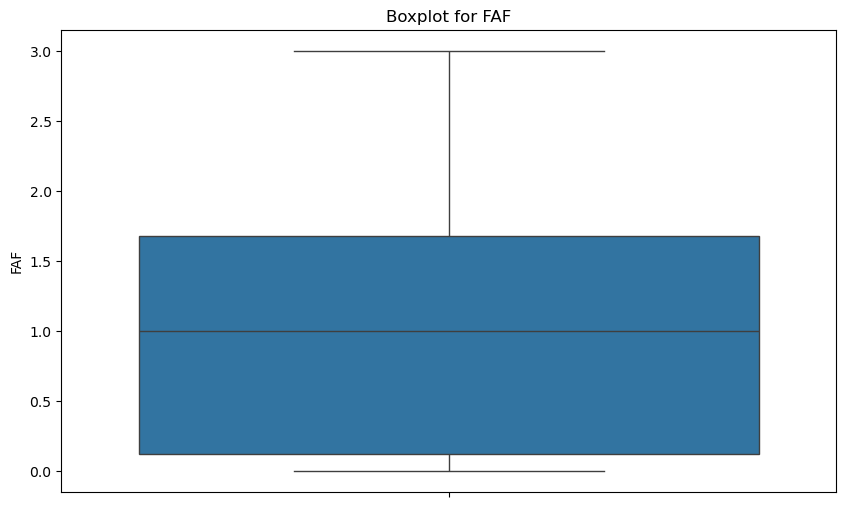

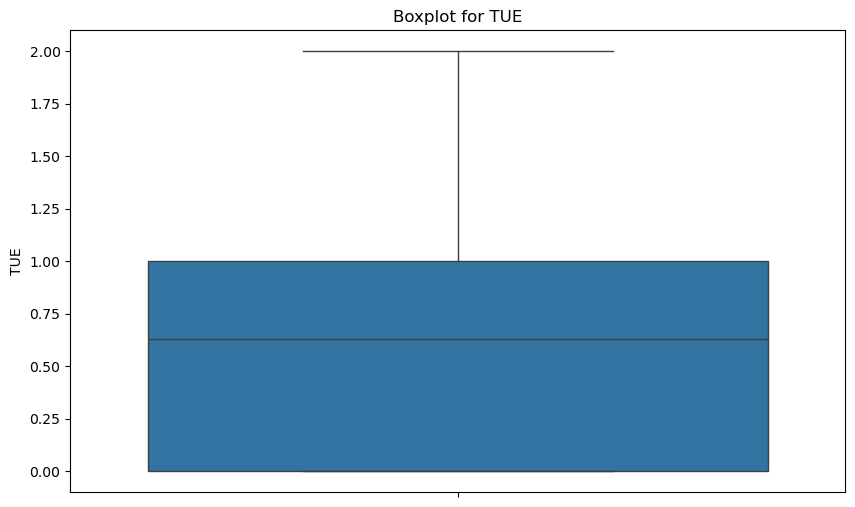

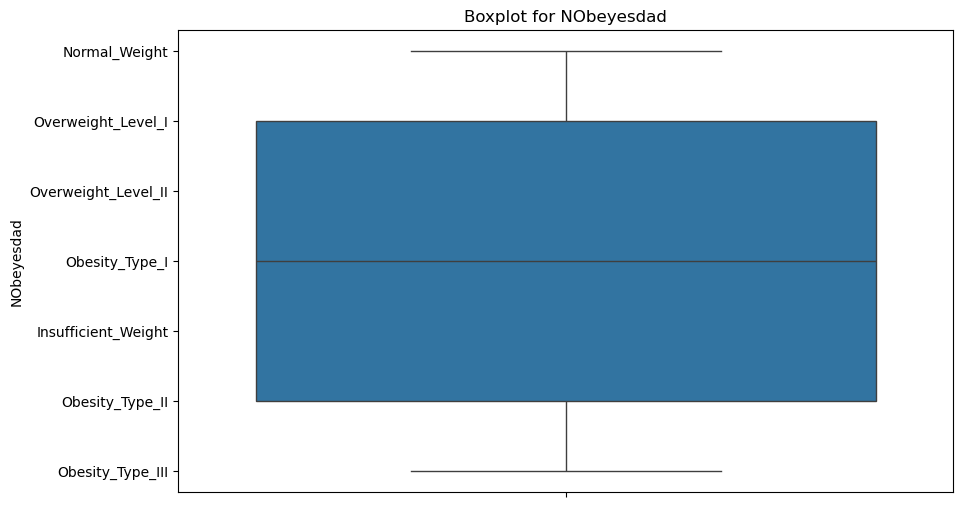

In [14]:
for col in continuous_columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

In [15]:
#encoding binary columns
df_prep = pd.get_dummies(df, columns=["Gender","family_history_with_overweight","FAVC","CAEC","SMOKE","SCC","CALC","MTRANS"])
df_prep.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,Normal_Weight,True,False,False,True,True,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,Normal_Weight,True,False,False,True,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,False
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,Normal_Weight,False,True,False,True,True,False,False,False,True,False,True,False,True,False,False,True,False,False,False,False,False,True,False
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,Overweight_Level_I,False,True,True,False,True,False,False,False,True,False,True,False,True,False,False,True,False,False,False,False,False,False,True
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,Overweight_Level_II,False,True,True,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False


In [16]:
#segeregating x and y
df_prep.drop('NObeyesdad', axis =1, inplace = True)

In [17]:
#replacing binary with int
df_prep = df_prep.replace({True: 1, False: 0})
df_prep.head()

C:\Users\bitka\AppData\Local\Temp\ipykernel_28964\526435866.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_prep = df_prep.replace({True: 1, False: 0})


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,0,1,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0


In [18]:
normalizer = StandardScaler()
X_data = normalizer.fit_transform(df_prep)
Y_data = df['NObeyesdad']

In [19]:
X_data.shape, Y_data.shape

((2087, 31), (2087,))

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=19)
print(f'training data shape: {x_train.shape} \n testing data shape: {x_test.shape}')    
print(f'training target shape: {y_train.shape} \n testing target shape: {y_test.shape}')

training data shape: (1669, 31) 
 testing data shape: (418, 31)
training target shape: (1669,) 
 testing target shape: (418,)


# Part 2: Machine Learning

1. Model Selection:

    ➢ Choose several machine learning algorithms (e.g., SVM, Decision Trees, Random Forest, Gradient Boosting, k-NN, etc.).

2. Model Training:

    ➢ Split the dataset into training and testing sets. (60,000 train and 10,000 test)

    ➢ Train each model on the training set.

3. Model Evaluation:

    ➢ Evaluate each model’s performance on the testing set using metrics such as accuracy, precision, recall, and F1-score.

    ➢ Use a confusion matrix to visualize the performance of each model.

In [35]:
# Initialize classifiers
models = {
    'Logistic regression': LR(max_iter = 1000),
    "Support Vector": SVC(),
    "Decision Tree": DTC(),
    "Random Forest": RFC(),
    "KNeighbours": KNN(),
    "Gradient Boosting": GBC(),}

# Train and evaluate each model
predictions = {}
compute_time = []
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Start time
    start_time = time.time()
    
    model.fit(x_train, y_train)
    
    # End time
    end_time = time.time()
    
    # Calculate runtime
    run_time = end_time - start_time
    
    compute_time.append((model_name, run_time))

    # Save the model as a pickle file
    filename = './models/'+model_name + 'Obesity-prediction-models.pkl'
    joblib.dump(model, filename)
    del model

    # import loaded model
    model_loaded = joblib.load(filename)
    y_pred = model_loaded.predict(x_test)
    results = {model_name: y_pred}
    predictions.update(results)
predictions = pd.DataFrame(predictions)

Training Logistic regression...
Training Support Vector...
Training Decision Tree...
Training Random Forest...
Training KNeighbours...
Training Gradient Boosting...


In [ ]:
# Assuming df is your DataFrame and you want to insert a new column 'new_column'
# predictions.insert(0, 'y_true', y_test)

In [36]:
predictions.to_csv('experiment_results/model_prediction-results_v01.csv', index=False)

# Evaluate the models
Evaluate each model’s performance on the testing set using metrics such as accuracy, precision, recall, and F1-score.

In [37]:
def weighted_accuracy(Y_true, Y_pred, model_name):
    # Calculate precision, recall, f1 score, and accuracy
    accuracy = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    f1 = f1_score(Y_true, Y_pred, average='weighted')

    weighte_performance = {'Accuracy': round(accuracy,3), 
                           'precision': round(precision, 3),
                           'recall': round(recall, 3), 
                           'f1_score': round(f1, 3)}
    df = pd.DataFrame([weighte_performance])
    df.rename(index = {0:model_name}, inplace = True)
    return df

In [45]:
weighted_accuracy_results = []
for i, name in enumerate(predictions.columns):
    #if i > 0:
    print(i, name)
    weighted_accuracy_results.append(weighted_accuracy(y_test, predictions.iloc[:,i], name))
weighted_accuracy_results = pd.concat(weighted_accuracy_results)
weighted_accuracy_results

0 Logistic regression
1 Support Vector
2 Decision Tree
3 Random Forest
4 KNeighbours
5 Gradient Boosting


,Accuracy,precision,recall,f1_score
Logistic regression,0.880,0.884,0.880,0.879
Support Vector,0.837,0.841,0.837,0.836
Decision Tree,0.914,0.915,0.914,0.914
Random Forest,0.943,0.948,0.943,0.943
KNeighbours,0.801,0.800,0.801,0.797
Gradient Boosting,0.962,0.962,0.962,0.961


In [49]:
weighted_accuracy_results.to_csv('experiment_results/Obesity_weighted_performance_results_v01.csv', index=False)

In [47]:
def Compute_macro_Accuracy(Y_true, Y_pred, model_name):
    acc = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred, average='macro')
    recall = recall_score(Y_true, Y_pred, average='macro')
    F1_score = f1_score(Y_true, Y_pred, average='macro')
    performances = {'Accuracy': round(acc, 3), 
                    'precision': round(precision, 3),
                    'recall': round(recall,3), 
                    'f1_score': round(F1_score,3)}
    df_macro = pd.DataFrame([performances])
    df_macro.rename(index = {0:model_name}, inplace = True)
    return df_macro

In [48]:
macro_accuracy_results = []
for i, name in enumerate(predictions.columns):
    #if i > 0:
    print(i, name)
    macro_accuracy_results.append(Compute_macro_Accuracy(y_test, predictions.iloc[:,i], name))

macro_accuracy_results = pd.concat(macro_accuracy_results)
macro_accuracy_results

0 Logistic regression
1 Support Vector
2 Decision Tree
3 Random Forest
4 KNeighbours
5 Gradient Boosting


,Accuracy,precision,recall,f1_score
Logistic regression,0.880,0.879,0.882,0.877
Support Vector,0.837,0.841,0.835,0.835
Decision Tree,0.914,0.914,0.914,0.914
Random Forest,0.943,0.947,0.941,0.942
KNeighbours,0.801,0.802,0.799,0.796
Gradient Boosting,0.962,0.960,0.962,0.961


In [50]:
macro_accuracy_results.to_csv('experiment_results/Obesity_macro_performance_results_v01.csv', index=False)

In [51]:
for i, name in enumerate(predictions.columns):
    #if i > 0:
    print(i, name, '\n')
    print(classification_report(y_test, predictions.iloc[:,i]))

0 Logistic regression 

                     precision    recall  f1-score   support

Insufficient_Weight       0.85      1.00      0.92        51
      Normal_Weight       0.90      0.73      0.81        60
     Obesity_Type_I       0.94      0.88      0.91        74
    Obesity_Type_II       0.89      0.97      0.93        66
   Obesity_Type_III       1.00      0.98      0.99        57
 Overweight_Level_I       0.84      0.77      0.80        60
Overweight_Level_II       0.74      0.84      0.79        50

           accuracy                           0.88       418
          macro avg       0.88      0.88      0.88       418
       weighted avg       0.88      0.88      0.88       418

1 Support Vector 

                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.88      0.89        51
      Normal_Weight       0.68      0.77      0.72        60
     Obesity_Type_I       0.82      0.85      0.83        74
    Obesity_Type_II       0.89      0.

#### Plot the confusion matrix to visualize the performance of each model.

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title, fontsize = 16, fontweight = 'bold')
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, tick_marks, fontweight = 'bold')
    plt.yticks(tick_marks, tick_marks, fontweight = 'bold')
    
    # Label the counts inside the confusion matrix cells
    thresh = cm.max() / 2.  # threshold to set text color
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label', fontweight = 'bold')
    plt.xlabel('Predicted label', fontweight = 'bold')
    plt.tight_layout()
    plt.show()

0 Logistic regression 



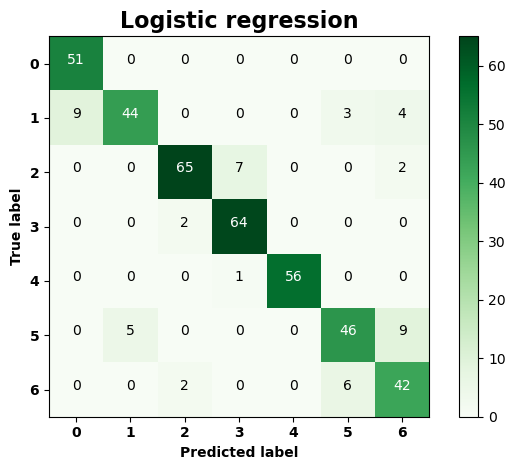

1 Support Vector 



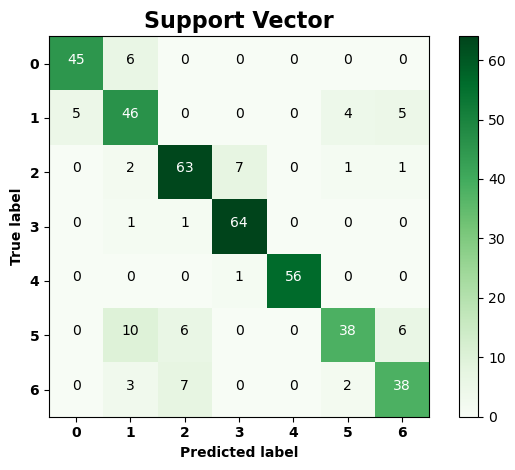

2 Decision Tree 



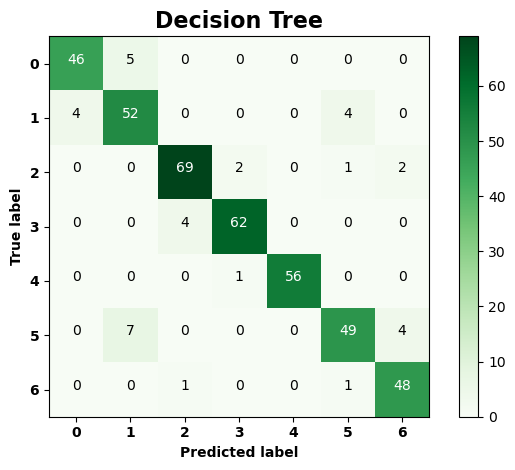

3 Random Forest 



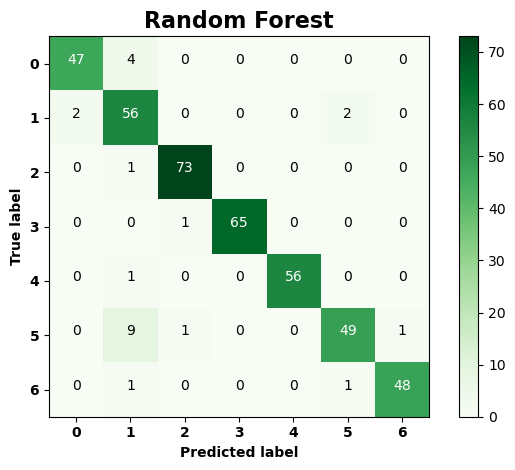

4 KNeighbours 



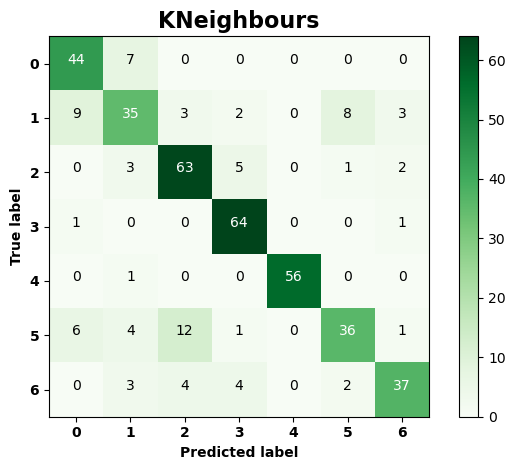

5 Gradient Boosting 



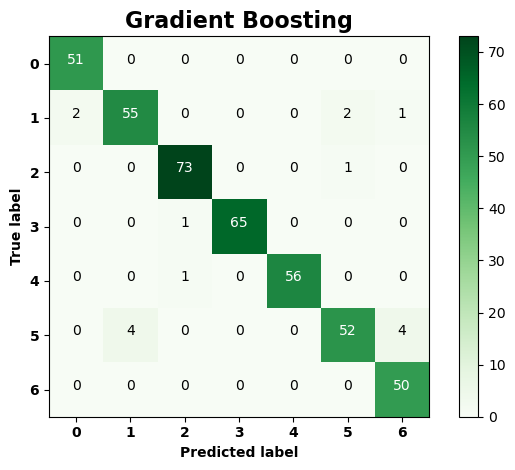

In [53]:
for i, name in enumerate(predictions.columns):
    
    print(i, name, '\n')
    cm = confusion_matrix(y_test, predictions.iloc[:,i])
    plot_confusion_matrix(cm, title=name)


# Hyperparameter Tuning

- **Grid Search:**

    - Perform grid search cross-validation to find the optimal hyperparameters for each model.
- Define hyperparameter for each model

In [64]:
# Define parameter grids for each model
param_grid_lr = {
    'C': [0.01, 0.1, 1.0, 5, 10], 'solver': ['newton-cg', 'sag', 'saga','lbfgs']}

param_grid_svc = {'C': [0.01, 0.1, 1.0, 5, 10], 'kernel': ['linear', 'rbf'],}

# Define the parameter grid for the DecisionTreeClassifier
param_grid_dt = {'max_depth': [None, 3, 7, 11], 'min_samples_split': [2, 5,  9],}

param_grid_rfc = {'n_estimators': [50, 70, 100, 120, 150], 'max_depth': [None, 5, 10, 15],} 

# Define the prmeters fot KNN
#param_grid_knn = {'n_neighbors': [1, 3, 5, 7,9], 'p': [1, 2, 5, 9] } 
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],  # Avoid 0 or excessively large values
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Avoid invalid metrics
}
# Define the parameter grid for GradientBoostingClassifier
param_grid_gb = {'n_estimators': [50, 70, 100, 120, 150], 'learning_rate': [0.001, 0.01, 0.1,  0.5],}

Parameters = [param_grid_lr, param_grid_svc, param_grid_dt, param_grid_rfc, param_grid_knn, param_grid_gb] 

In [66]:
best_estimators = {}
predictions_best = {}
best_run_time = []
for (model_name, model), param_grid in zip(models.items(), Parameters):
    if model_name == "KNeighbours" or model_name == "Gradient Boosting":
       print('Skip for KNeighbours or Gradient Boosting')
    else:
        print(f"Running GridSearchCV for {model_name}...")
        start_time = time.time()
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
        grid_search.fit(x_train, y_train)
        
        end_time = time.time()
        
        run_time = end_time - start_time
    
    best_run_time.append((model_name, run_time))
    
    best_model = grid_search.best_estimator_
    # Save the model as a pickle file
    filename_best = './models/'+model_name + 'obesity_best_model_v01.pkl'
    joblib.dump(best_model, filename_best)
    del best_model
    # import loaded model
    model_loaded_best = joblib.load(filename_best)

    y_pred = model_loaded_best.predict(x_test)
    results_cv = {model_name: y_pred}
    predictions_best.update(results_cv)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}\n")
    #print(model_name, model, param_grid)
    
predictions_best = pd.DataFrame(predictions_best)

Running GridSearchCV for Logistic regression...
Best parameters for Logistic regression: {'C': 10, 'solver': 'newton-cg'}
Best cross-validation score for Logistic regression: 0.9310963658269047

Running GridSearchCV for Support Vector...
Best parameters for Support Vector: {'C': 5, 'kernel': 'linear'}
Best cross-validation score for Support Vector: 0.9604592616568665

Running GridSearchCV for Decision Tree...
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 2}
Best cross-validation score for Decision Tree: 0.925115534696373

Running GridSearchCV for Random Forest...
Best parameters for Random Forest: {'max_depth': 15, 'n_estimators': 120}
Best cross-validation score for Random Forest: 0.9418927909945876

Skip for KNeighbours or Gradient Boosting
Best parameters for KNeighbours: {'max_depth': 15, 'n_estimators': 120}
Best cross-validation score for KNeighbours: 0.9418927909945876

Skip for KNeighbours or Gradient Boosting
Best parameters for Gradient Boosting:

In [67]:
predictions_best

,Logistic regression,Support Vector,Decision Tree,Random Forest,KNeighbours,Gradient Boosting
0,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III
1,Overweight_Level_I,Overweight_Level_I,Overweight_Level_I,Normal_Weight,Normal_Weight,Normal_Weight
2,Normal_Weight,Normal_Weight,Normal_Weight,Normal_Weight,Normal_Weight,Normal_Weight
3,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I
4,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I
...,...,...,...,...,...,...
413,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III,Obesity_Type_III
414,Overweight_Level_I,Overweight_Level_I,Overweight_Level_I,Overweight_Level_I,Overweight_Level_I,Overweight_Level_I
415,Obesity_Type_II,Obesity_Type_II,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I,Obesity_Type_I
416,Overweight_Level_I,Overweight_Level_II,Overweight_Level_II,Overweight_Level_II,Overweight_Level_II,Overweight_Level_II


In [68]:
best_weighted_accuracy_results = []
for i, name in enumerate(predictions_best.columns):
    #if i > 0:
    #print(i, name)
    best_weighted_accuracy_results.append(weighted_accuracy(y_test, predictions_best.iloc[:,i], name))
best_weighted_accuracy_results = pd.concat(best_weighted_accuracy_results)
best_weighted_accuracy_results

,Accuracy,precision,recall,f1_score
Logistic regression,0.940,0.942,0.940,0.940
Support Vector,0.967,0.968,0.967,0.967
Decision Tree,0.921,0.923,0.921,0.921
Random Forest,0.938,0.946,0.938,0.939
KNeighbours,0.938,0.946,0.938,0.939
Gradient Boosting,0.938,0.946,0.938,0.939


In [69]:
best_weighted_accuracy_results.to_csv('experiment_results/Obesity_best_model_weighted_performance_results_v01.csv', index=False)

In [70]:
best_macro_accuracy_results = []
for i, name in enumerate(predictions_best.columns):
    #if i > 0:
    print(i, name)
    best_macro_accuracy_results.append(Compute_macro_Accuracy(y_test, predictions_best.iloc[:,i], name))

best_macro_accuracy_results = pd.concat(best_macro_accuracy_results)
best_macro_accuracy_results

0 Logistic regression
1 Support Vector
2 Decision Tree
3 Random Forest
4 KNeighbours
5 Gradient Boosting


,Accuracy,precision,recall,f1_score
Logistic regression,0.940,0.938,0.940,0.938
Support Vector,0.967,0.965,0.967,0.965
Decision Tree,0.921,0.922,0.922,0.922
Random Forest,0.938,0.946,0.936,0.938
KNeighbours,0.938,0.946,0.936,0.938
Gradient Boosting,0.938,0.946,0.936,0.938


In [73]:
best_macro_accuracy_results.to_csv('experiment_results/Obesity_best_model_macro_performance_results_v01.csv', index=False)

In [72]:
for i, name in enumerate(predictions_best.columns):
    print(i, name, '\n')
    print(classification_report(y_test, predictions_best.iloc[:,i]))

0 Logistic regression 

                     precision    recall  f1-score   support

Insufficient_Weight       0.86      1.00      0.93        51
      Normal_Weight       0.94      0.83      0.88        60
     Obesity_Type_I       0.99      0.96      0.97        74
    Obesity_Type_II       0.97      0.98      0.98        66
   Obesity_Type_III       1.00      0.98      0.99        57
 Overweight_Level_I       0.90      0.90      0.90        60
Overweight_Level_II       0.90      0.92      0.91        50

           accuracy                           0.94       418
          macro avg       0.94      0.94      0.94       418
       weighted avg       0.94      0.94      0.94       418

1 Support Vector 

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      1.00      0.96        51
      Normal_Weight       0.98      0.92      0.95        60
     Obesity_Type_I       1.00      0.96      0.98        74
    Obesity_Type_II       0.97      1.

0 Logistic regression 



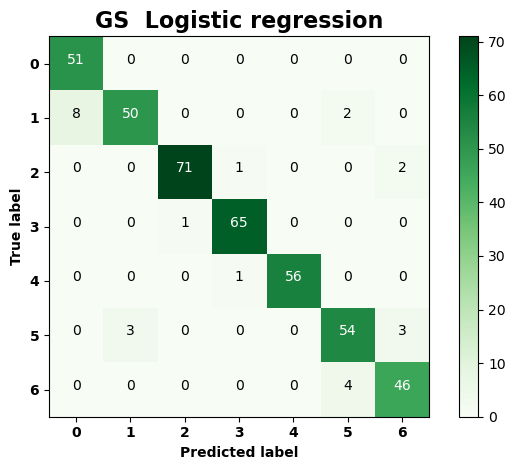

1 Support Vector 



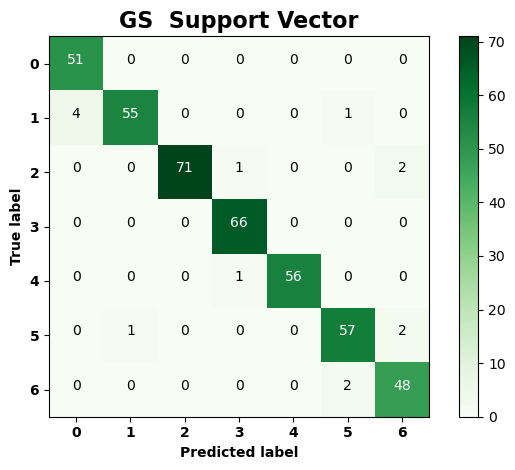

2 Decision Tree 



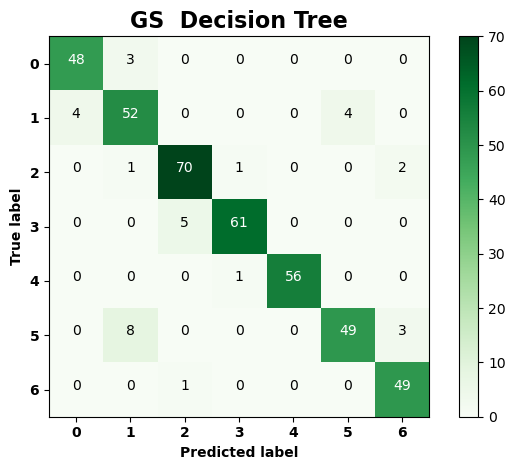

3 Random Forest 



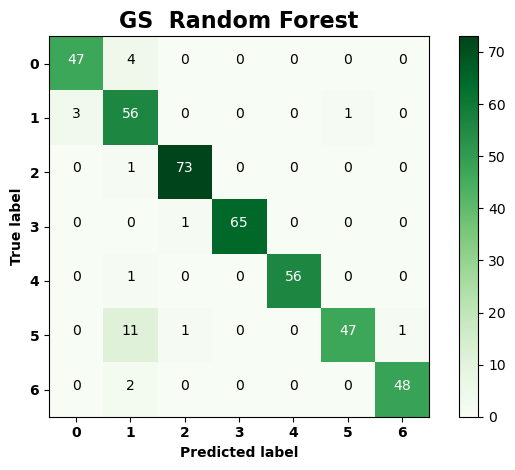

4 KNeighbours 



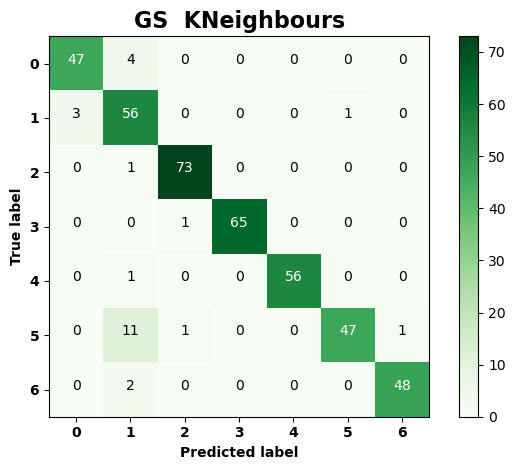

5 Gradient Boosting 



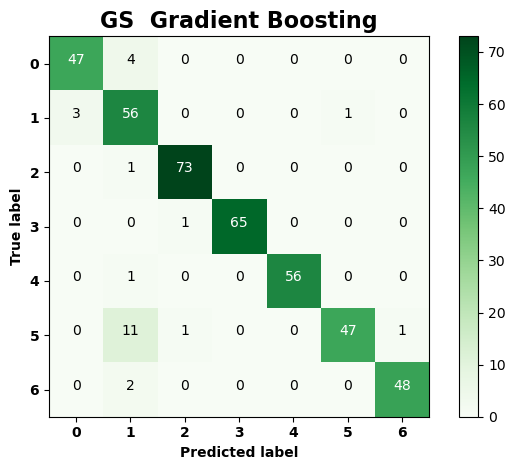

In [74]:
for i, name in enumerate(predictions_best.columns):
    print(i, name, '\n')
    cm = confusion_matrix(y_test, predictions_best.iloc[:,i])
    plot_confusion_matrix(cm, title='GS  '+  name )

In [81]:
def ROC_curves(Y_test, Y_pred, model_name = None):
    # Binarize the output labels (convert them to one-vs-rest format)
    y_true = label_binarize(Y_test, classes=np.unique(Y_test))
    Y_pred = label_binarize(Y_pred, classes=np.unique(Y_pred))
    n_classes = y_true.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], Y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area (aggregate of all classes)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), Y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class and the micro-average ROC curve
    plt.figure(figsize = (10,8))
    plt.plot(fpr["micro"], tpr["micro"], 
             label='Micro-Average (A = {0:0.2f})'.format(roc_auc["micro"]))

    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan']
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='Class {0} (A = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontweight = 'bold')
    plt.ylabel('True Positive Rate', fontweight = 'bold')
    plt.xticks(fontweight = 'bold')
    plt.yticks(fontweight = 'bold')
    plt.title(model_name + ' ROCs \n  Obesity Levels Classification', fontweight = 'bold', fontsize = 16)
    plt.legend(loc="lower right", ncol = 2)
    plt.show()

In [83]:
def Precision_Recall_curves(Y_test, Y_pred, model_name = None):
    # Compute Precision-Recall curve for each class
    precision = dict()
    recall = dict()
    average_precision = dict()

    # Binarize the output labels (convert them to one-vs-rest format for multi-class precision-recall)
    y_true = label_binarize(Y_test, classes=np.unique(Y_test))
    Y_pred = label_binarize(Y_pred, classes=np.unique(Y_pred))
    n_classes = y_true.shape[1]

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], Y_pred[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], Y_pred[:, i])

    # Compute micro-average Precision-Recall curve and average precision score
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), Y_pred.ravel())
    average_precision["micro"] = average_precision_score(y_true, Y_pred, average="micro")

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan']
    plt.plot(recall["micro"], precision["micro"], label='Micro-average P-R curve (A = {0:0.2f})'
                                                       ''.format(average_precision["micro"]))

    for i in range(n_classes):
        plt.plot(recall[i], precision[i], color=colors[i], lw=2,
                 label='Class {0} (A = {1:0.2f})'.format(i, average_precision[i]))

    plt.xlabel('Recall', fontweight = 'bold')
    plt.ylabel('Precision', fontweight = 'bold')
    plt.xticks(fontweight = 'bold')
    plt.yticks(fontweight = 'bold')
    plt.title(model_name + ' P-R curves \n Obesity Levels Classification', fontweight = 'bold', fontsize = 16)
    plt.legend(loc="lower left", ncol = 2)
    plt.show()

0 Logistic regression 



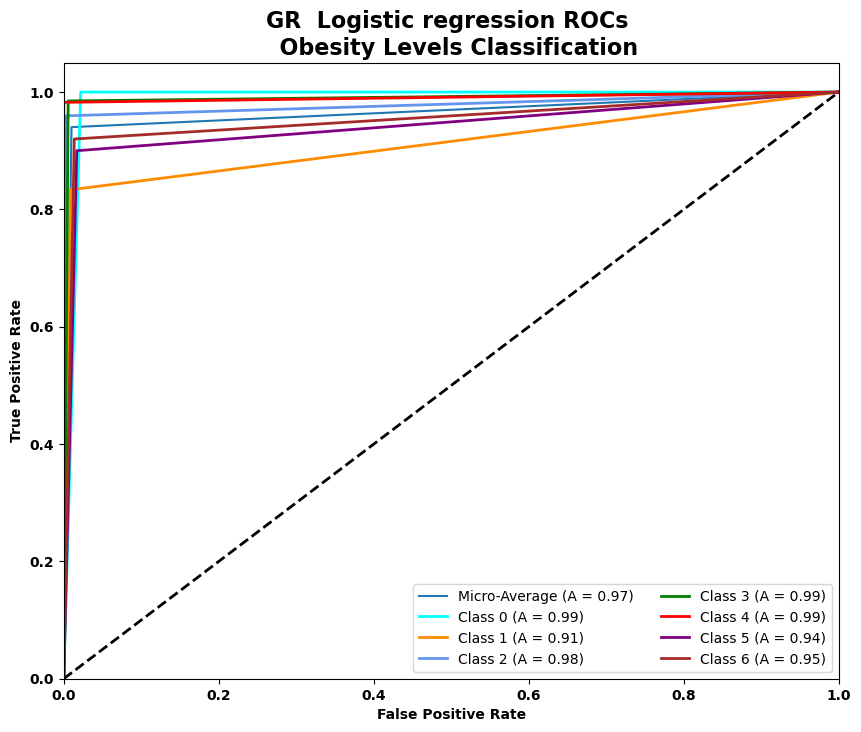

1 Support Vector 



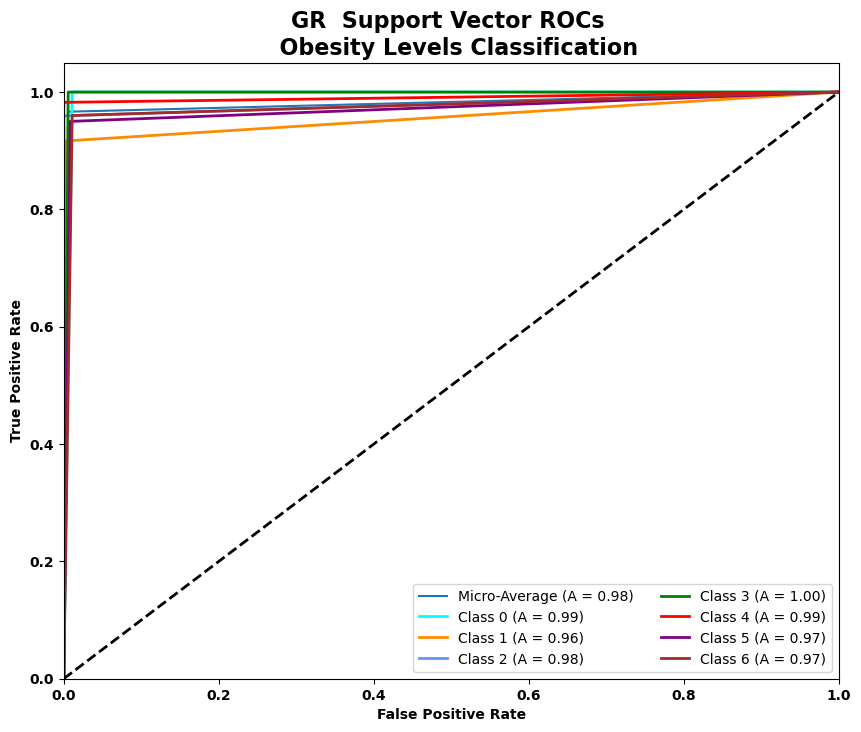

2 Decision Tree 



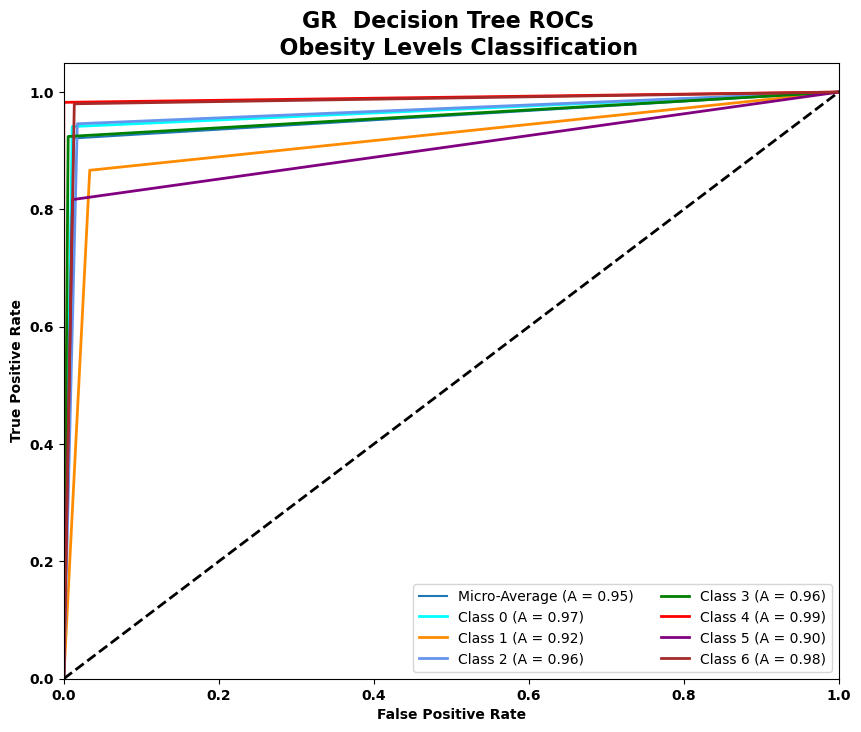

3 Random Forest 



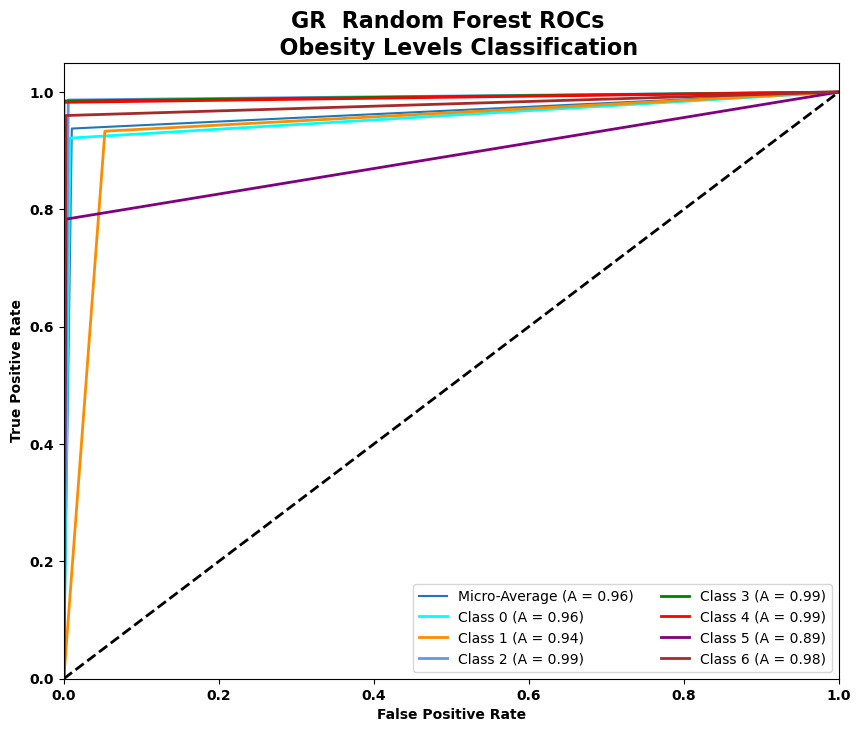

4 KNeighbours 



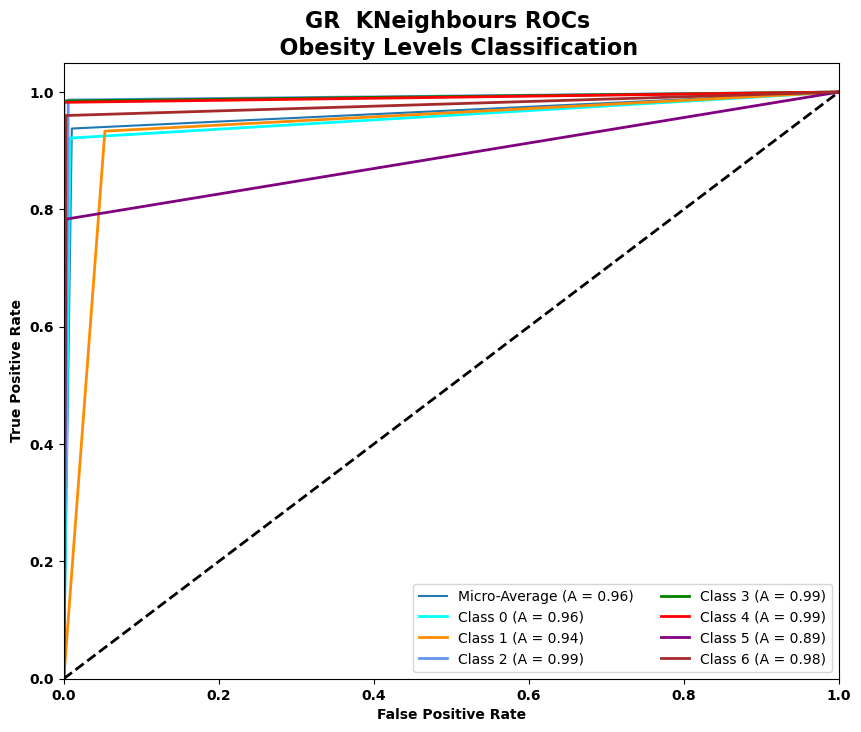

5 Gradient Boosting 



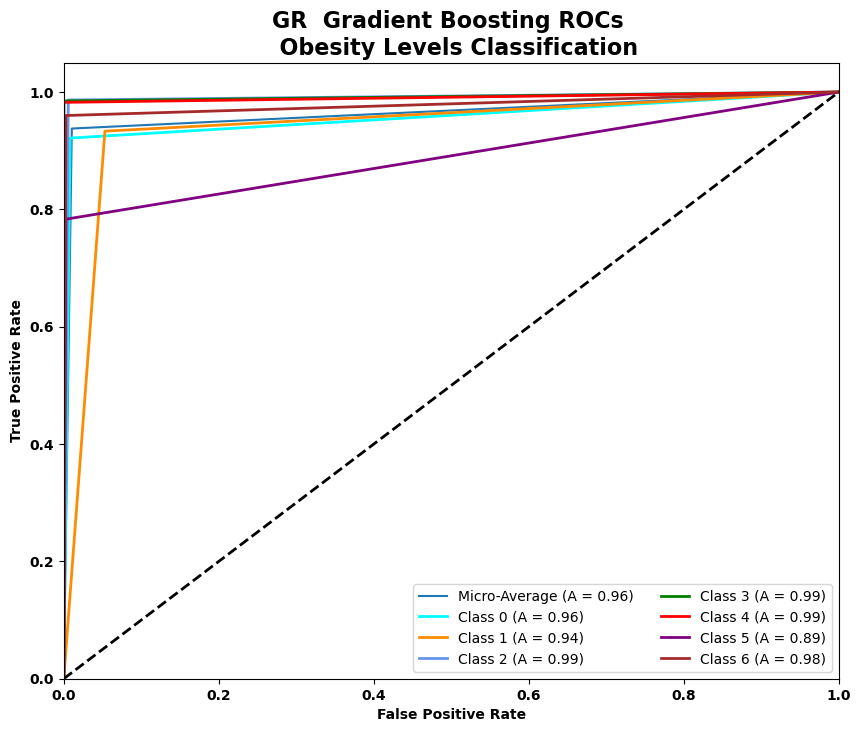

In [84]:
for i, name in enumerate(predictions_best.columns):
    print(i, name, '\n')
    ROC_curves(y_test, predictions_best.iloc[:,i], model_name ='GR  '+ name)

0 Logistic regression 



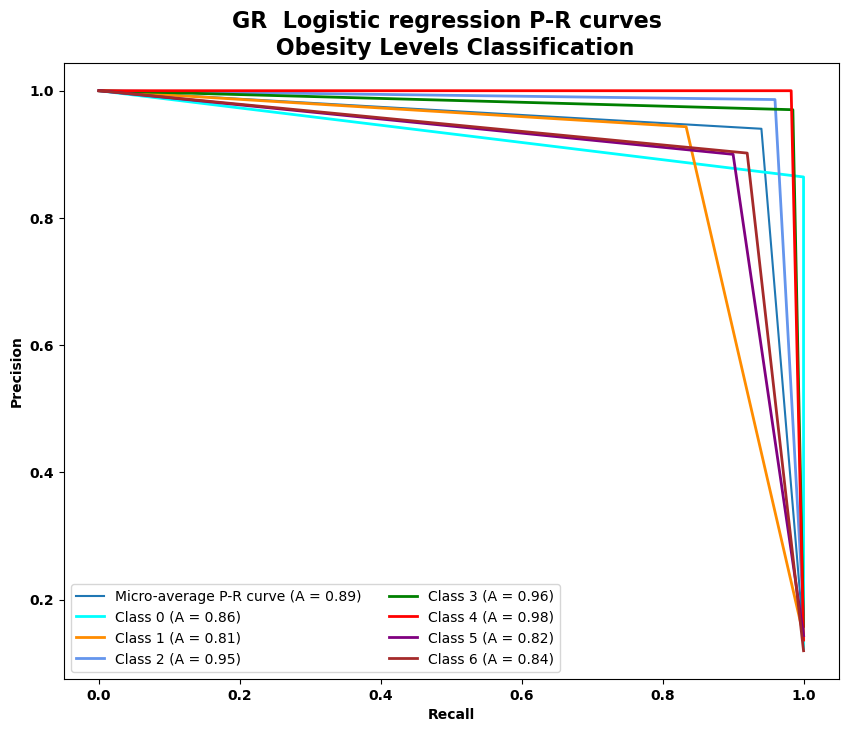

1 Support Vector 



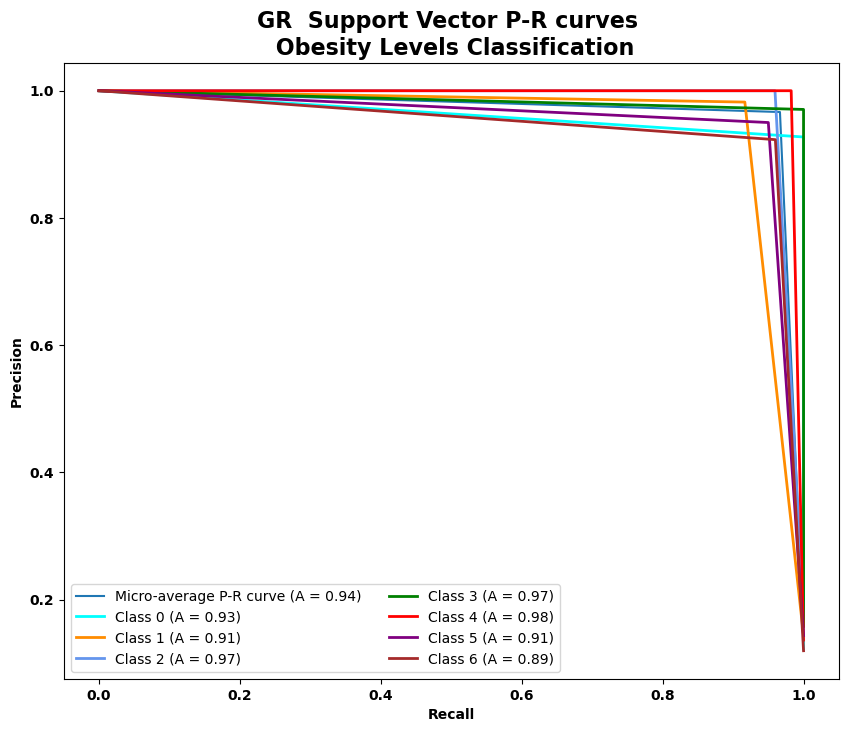

2 Decision Tree 



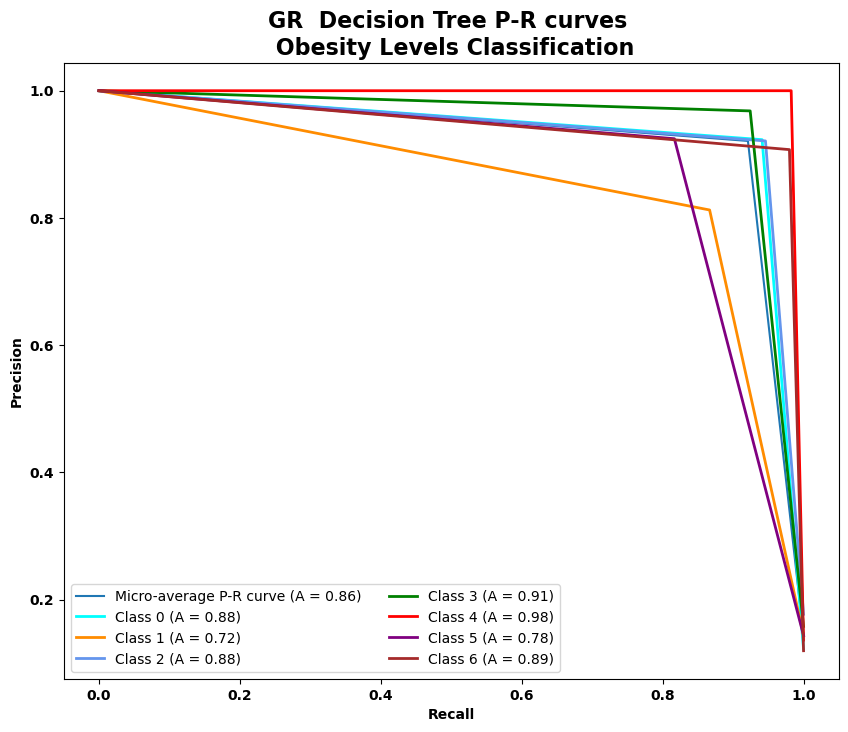

3 Random Forest 



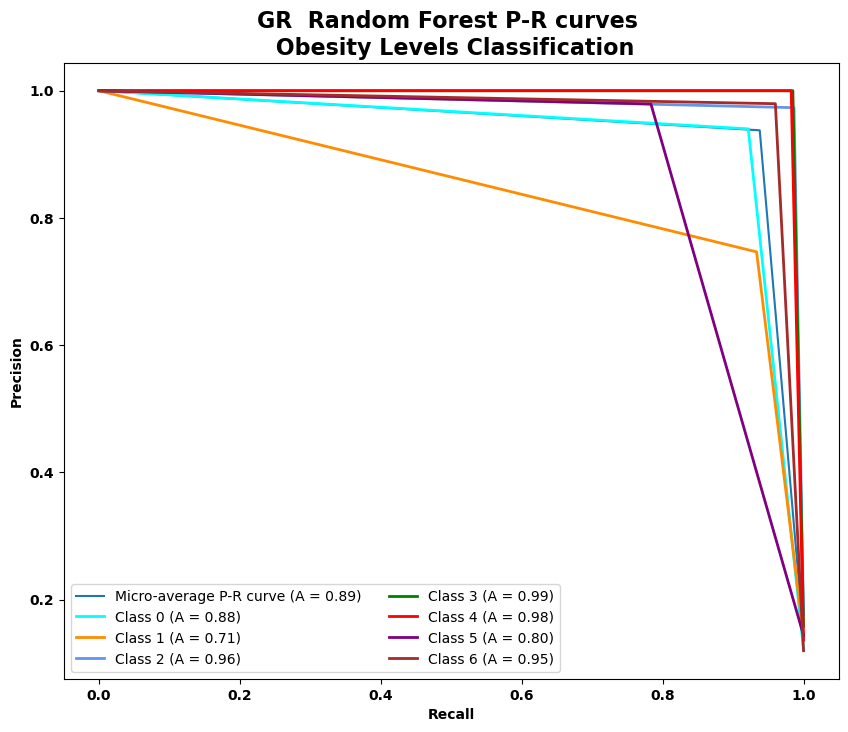

4 KNeighbours 



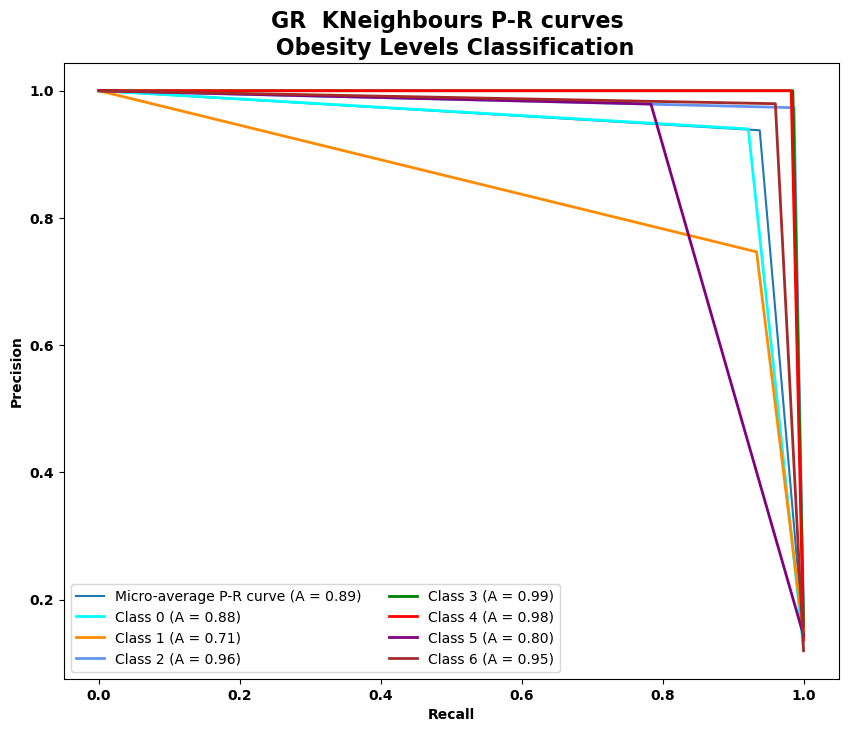

5 Gradient Boosting 



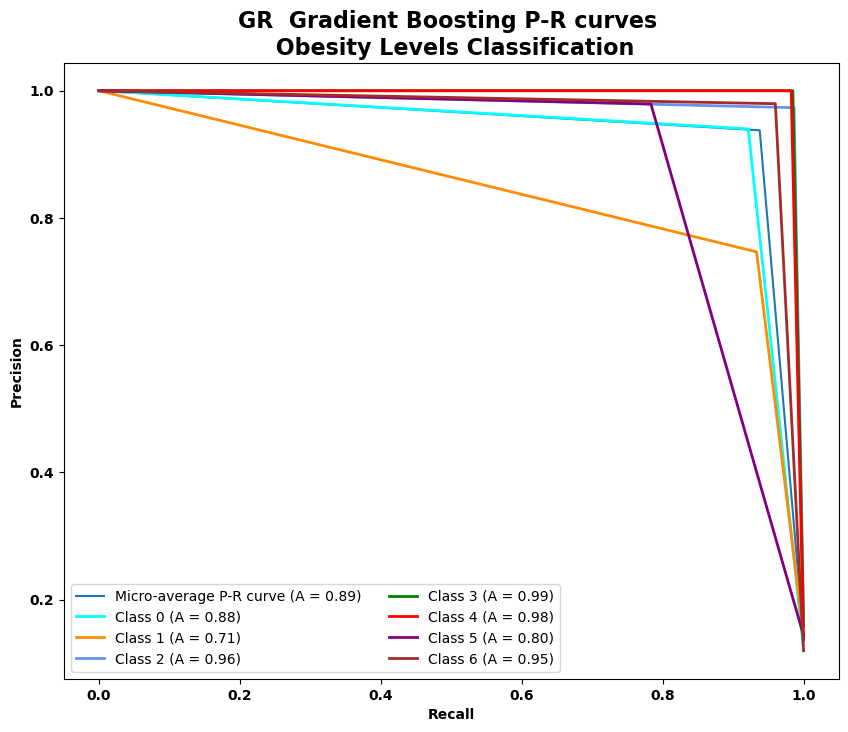

In [85]:
for i, name in enumerate(predictions_best.columns):
    print(i, name, '\n')
    Precision_Recall_curves(y_test, predictions_best.iloc[:,i], model_name ='GR  '+ name)